# ADS Project 3 Group 4

## Libraries and Settings

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from PIL import Image
from scipy.io import loadmat

from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from keras.callbacks import EarlyStopping
from keras import models
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [2]:
"""
Path
"""
DATA_PATH = "../data/train_set"
IMAGE_FOLDER = os.path.join(DATA_PATH, "images")
POINTS_FOLDER = os.path.join(DATA_PATH, "points")
LABELS_FOLDER = DATA_PATH

## Read Training Data

In [3]:
def read_all_images(height = 750, width = 1000, crop_gray = False, points = None):
    """
    Read 2500 training images from the IMAGE_FOLDER, resized to 'height x width'
    
    :param height: resized height of images
    :param width: resized width of images
    :return: a 4d numpy array in form of (index, height, width, channels), channels is RGB 
    """
    files = [file for file in os.listdir(IMAGE_FOLDER) if file.endswith('.jpg')]
    files.sort()
    
    
    face_images_arr = np.zeros((len(files), height, width, 1 if crop_gray else 3 ))
    
    for index, filename in enumerate(files):
        face_img = Image.open(os.path.join(IMAGE_FOLDER, filename))
        # if crop_gray, then the image will be cropped to fit the facial part
        # and then it will return a grayscale version
        if crop_gray:
            face_img = face_img.convert('L')

            face_points = points[index]
            # calculate crop position
            left = np.min(face_points[:,0]) 
            right = np.max(face_points[:,0]) 
            top = np.min(face_points[:,1])
            bot = np.max(face_points[:,1])

            face_img = face_img.crop((left,top,right,bot))
        
        face_img = face_img.resize((width, height))
        # fit the dimension
        face_images_arr[index] = np.array(face_img).reshape((height,width, -1))
        
    return face_images_arr

def read_labels():
    """
    Read the image labels from the label.csv file
    :return: a pandas.DataFrame with 3 columns: 'emotion_idx','emotion_cat','type'
    """
    labels_df = pd.read_csv(os.path.join(LABELS_FOLDER, 'label.csv'))
    labels_df = labels_df.loc[:,['emotion_idx','emotion_cat','type']]
    return labels_df
    

def read_all_points():
    """
    Read all face coordinates points
    :return: a tuple of shape (2500, 78, 2). Because for each of 2500 images there are 78 points associated with it
    """
    files = [file for file in os.listdir(POINTS_FOLDER) if file.endswith('.mat')]
    files.sort()
    
    face_points = np.zeros((len(files), 78, 2))
    for index, filename in enumerate(files):
        face_points_dict = loadmat(os.path.join(POINTS_FOLDER, filename))
    
        face_points[index] = face_points_dict.get('faceCoordinatesUnwarped',  face_points_dict.get('faceCoordinates2'))
    return face_points

def load_data(loadImage = False, height = 750, width = 1000, crop_gray = False):
    """
    Load training data from local files
    
    :param loadImage: if it's False, this function will not load original images
    :return: a tuple (images, points, labels)
        if loadImage is False, the 'images' will None. Otherwise its a numpy array with shape (2500,750,1000,3)
        points is a numpy array with shape (2500, 78, 2)
        labels is a pandas.DataFrame
    """
    
    face_images_points = read_all_points()
    
    face_images_ndarr =  read_all_images(height, width, crop_gray, face_images_points) if loadImage else None
    labels = read_labels()
    
    return face_images_ndarr, face_images_points, labels



def show_image(index, all_images = None):
    """
    Display the (index)th image.
    all_images is passed, the this image numpy array can be easily retrieved from it. 
    Otherwise the original images needs to be read from disk
    
    :param index: the index to specify which image to disply
    :param all_images: the return value of 'read_all_images' function
    """
    
    if all_images is not None and index < len(all_images):
        face_img_arr = all_images[index].astype('uint8')
        if face_img_arr.shape[2] == 1:
            face_img_arr = face_img_arr.reshape((face_img_arr.shape[0],face_img_arr.shape[1]))
    else:
        face_img_arr = plt.imread(os.path.join(IMAGE_FOLDER, f"{index:04}.jpg"))
    plt.imshow(face_img_arr, cmap='gray')
    plt.show()


In [4]:
"""
Read images with 200x200 resolution and facial points, labels
"""
height = 200
width = 200
images, points, labels = load_data(loadImage= True,crop_gray=True, height = height, width = width)

In [5]:
if images is not None:
    print("shape of image",images.shape)
    print(f"memory of image ndarray is {sys.getsizeof(images)/1024/1024/1024:.2f} GB")
if points is not None:
    print("shape of points",points.shape)

shape of image (2500, 200, 200, 1)
memory of image ndarray is 0.75 GB
shape of points (2500, 78, 2)


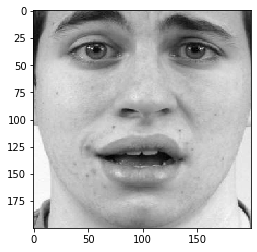

emotion_idx          18
emotion_cat        Awed
type           compound
Name: 2001, dtype: object


In [6]:
example_number = 2001
show_image(example_number,images)
print(labels.iloc[example_number])

## Machine Learning Models

In [7]:
"""
Preprocess the points input and extract the target y
"""

X_points = points.reshape((points.shape[0], -1))
y = labels['emotion_idx'].values - 1
print(X_points.shape, y.shape)

(2500, 156) (2500,)


In [8]:
def k_fold_validation(model, X, y, fold = 5, random_state = 13):
    """
    k-fold cross validation of sklearn classifier using X and y
    
    :param model: sklearn-compatible classifier with fit and score methods
    :param X: the feature matrix
    :param y: the target
    :param fold: the number of fold
    :param random_state: random seed for k-fold splitting
    
    :return: average accuracy for the model
    """
    
    kfold = StratifiedKFold(n_splits=fold, shuffle=True, random_state=random_state)
    
    avg_accuracy = 0
    for train_index, val_index in kfold.split(X, y):

        # split traning set and validation set
        X_train = X[train_index]
        y_train = y[train_index]

        X_test = X[val_index]
        y_test = y[val_index]

        # standardize
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test =scaler.transform(X_test)

        # fit
        model.fit(X_train, y_train)

        avg_accuracy += model.score(X_test, y_test)

    return avg_accuracy / fold


In [9]:
"""
1. Dummy baseline
"""
dummy_model = DummyClassifier()
avg_dummy_acc = k_fold_validation(dummy_model, X_points, y)
print("Average accuracy of the dummy model is: ", avg_dummy_acc)

Average accuracy of the dummy model is:  0.04482188806458916


In [10]:
"""
2. Decision Tree
"""
model = DecisionTreeClassifier()
avg_dt_acc = k_fold_validation(model, X_points, y)
print("Average accuracy of the decision tree model is: ", avg_dt_acc)

Average accuracy of the decision tree model is:  0.13602063528232605


In [11]:
"""
3. Random Forest with different number of trees
"""

for trees in [50,100,200,300,500]:
    model = RandomForestClassifier(n_estimators= trees)
    avg_rf_acc = k_fold_validation(model, X_points, y)
    print(f"Average accuracy of the random forest with {trees} trees is: ", avg_rf_acc)

Average accuracy of the random forest with 50 trees is:  0.20485617575179454
Average accuracy of the random forest with 100 trees is:  0.21153352431106195
Average accuracy of the random forest with 200 trees is:  0.2028802815925585
Average accuracy of the random forest with 300 trees is:  0.21200264527959617
Average accuracy of the random forest with 500 trees is:  0.2104493798023895


In [12]:
"""
4. KNN with different number of neighbors
"""
for nn in [10,30,50,100,200,300,500]:
    model = KNeighborsClassifier(n_neighbors= nn)
    avg_knn_acc = k_fold_validation(model, X_points, y)
    print(f"Average accuracy of the knn with k={nn} is: ", avg_knn_acc)

Average accuracy of the knn with k=10 is:  0.11792360521942975
Average accuracy of the knn with k=30 is:  0.10797320526358727
Average accuracy of the knn with k=50 is:  0.10246526518408854
Average accuracy of the knn with k=100 is:  0.10690413882957076
Average accuracy of the knn with k=200 is:  0.10167924794494909
Average accuracy of the knn with k=300 is:  0.0980433536177672
Average accuracy of the knn with k=500 is:  0.09430854768377811


In [14]:
"""
5. Logistic regression
"""
for C in [0.1,10,50,100]:
    model = LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=5000, random_state=13, C = C)
    avg_logistic_acc = k_fold_validation(model,X_points, y)
    print(f"Average accuracy of the logistic model with C={C} is: ", avg_logistic_acc)

Average accuracy of the logistic model with C=0.1 is:  0.46920033534855204
Average accuracy of the logistic model with C=10 is:  0.5391548420598627
Average accuracy of the logistic model with C=50 is:  0.5171143232299611
Average accuracy of the logistic model with C=100 is:  0.5063182436150508


In [15]:
"""
6. Linear SVC with different penalties
"""

for C in [0.03,0.1, 0.5, 1]:
    model = LinearSVC(max_iter = 5000, C=0.1)
    avg_linearsvc_acc = k_fold_validation(model,X_points, y)
    print(f"Average accuracy of the LinearSVC model with C={C} is: ", avg_logistic_acc)

Average accuracy of the LinearSVC model with C=0.03 is:  0.5063182436150508
Average accuracy of the LinearSVC model with C=0.1 is:  0.5063182436150508
Average accuracy of the LinearSVC model with C=0.5 is:  0.5063182436150508
Average accuracy of the LinearSVC model with C=1 is:  0.5063182436150508


In [16]:
"""
7. SVC with rbf kernel and poly kernel with default settings
"""
model = SVC(kernel='rbf')
avg_rbfSVC_acc = k_fold_validation(model,X_points, y)
print(f"Average accuracy of the SVC model using rbf kernel is: ", avg_rbfSVC_acc)

model = SVC(kernel='poly')
avg_polySVC_acc = k_fold_validation(model,X_points, y)
print(f"Average accuracy of the SVC model using poly kernel is: ", avg_polySVC_acc)

Average accuracy of the SVC model using rbf kernel is:  0.1956513321777882
Average accuracy of the SVC model using poly kernel is:  0.16845832700260666


## Feedforward Neural Network Using Facial Points

In [17]:
def create_ff_model(input_shape, hidden_layers = (512,) , outputs = 22, optimizer = 'adam'):
    """
    Create a feedforward model without any regularization
    
    :param input_shape: the size of input a 2-tupple
    :param hidden_layers: the hidden units of each hidden layers
    :param outputs: the number of expected output labels
    
    :return: compiled feedforwad nn model
    """
    if len(hidden_layers) < 1:
        raise Exception("Wrong parameter for hidden layer units")
        
    ff_model = models.Sequential()
    
    # input layer
    ff_model.add(layers.Dense(hidden_layers[0], activation='relu', input_shape = input_shape))
                 
    # add hidden layers
    for index in range(1, len(hidden_layers)):
        ff_model.add(layers.Dense(hidden_layers[index], activation='relu'))
    
    # output layer
    ff_model.add(layers.Dense(outputs, activation='softmax'))
    # rmsprop
    
    ff_model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics = ['acc'])
    
    return ff_model

In [18]:
def create_regularized_ff_model(input_shape, hidden_layers = (512,) , outputs = 22, optimizer = 'adam', l2 = 0.01):
    """
    Create a feedforward model `with` any regularization
    
    :param input_shape: the size of input a 2-tupple
    :param hidden_layers: the hidden units of each hidden layers
    :param outputs: the number of expected output labels
    
    :return: compiled feedforwad nn model
    """
    if len(hidden_layers) < 1:
        raise Exception("Wrong parameter for hidden layer units")
        
    ff_model = models.Sequential()
    
    l2_regularizer = regularizers.l2(l2)
    
    # input layer
    ff_model.add(layers.Dense(hidden_layers[0], activation='relu', input_shape = input_shape, kernel_regularizer = l2_regularizer))
#     ff_model.add(layers.Dropout(0.5))         
    # add hidden layers
    for index in range(1, len(hidden_layers)):
        ff_model.add(layers.Dense(hidden_layers[index], activation='relu', kernel_regularizer = l2_regularizer))
#         ff_model.add(layers.Dropout(0.5))
    # output layer
    ff_model.add(layers.Dense(outputs, activation='softmax'))
    # rmsprop
    
    ff_model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics = ['acc'])
    
    return ff_model

In [19]:
def k_fold_feedforward_points(model, X, y, fold = 5, random_state = 13):
    """
    Run k-fold cross validation for keras neural network model
    
    :param model_create_function: the function used to creat a compiled keras neural network model
    :param input_shape: the size of input a 2-tupple
    :param hidden_layer: the same as `create_ff_model` function
    :param X: the feature matrix
    :param y: the target
    :param fold: the number of fold
    :param random_state: random seed for k-fold splitting
    """
    
    # split folder
    kfold = StratifiedKFold(n_splits=fold, shuffle=True, random_state=random_state)
    
    avg_accuracy = 0
    histories = []
    # 5-fold 
    for train_index, val_index in kfold.split(X, y):
        # split traning set and validation set
        X_train = X[train_index]
        y_train = y[train_index]

        X_test = X[val_index]
        y_test = y[val_index]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test =scaler.transform(X_test)

        y_test = to_categorical(y_test)
        y_train = to_categorical(y_train)

        # early stopping
        callbacks = [
          EarlyStopping(
            monitor='val_loss', patience=5, verbose=0)
          ]


        history = model.fit(X_train,y_train,
                                         epochs = 20, 
                                        batch_size = 100,
                                         workers = 6,
                                         validation_data = (X_test, y_test),
                                        verbose = False,
                                        shuffle = True,
                                        callbacks = callbacks)
        histories.append(history)
        avg_accuracy += model.evaluate(X_test, y_test, verbose = False)[1]
    return histories, avg_accuracy / fold



In [20]:
def draw_training_validation_graph(history_obj):
    """
    Draw the loss and accuracy plot using the history_obj
    
    :param history_obj: the history object returned by calling fit method of keras' model
    
    """
    loss_values = history_obj.history['loss']
    val_loss_valus = history_obj.history['val_loss']
    acc = history_obj.history['acc']
    val_acc = history_obj.history['val_acc']
    
    epochs = range(1,len(val_loss_valus) + 1)
    
    fig, axs = plt.subplots(1,2, figsize = (16,4))

    axs[0].plot(epochs, loss_values, 'bo', label='Training Loss')
    axs[0].plot(epochs, val_loss_valus, 'r', label='Validation Loss')
    axs[0].set_title('Training and Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    
    axs[1].plot(epochs, acc, 'bo', label='Training Acc')
    axs[1].plot(epochs, val_acc, 'r', label='Validation Acc')
    axs[1].set_title('Training and Validation Acc')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    
    
    plt.show()

In [21]:
"""
1. Sklearn MLPClassifier with different hidden layers and learning rate
"""

for learning_rate in ['adaptive', 'constant']:
    for hidden_layer in [(32,32), (64,), (64,64), (128,), (128,128), (256,), (256,256), (512,), (512,512), (1024,)]:
        model = MLPClassifier(hidden_layer_sizes=hidden_layer, learning_rate=learning_rate,
                     early_stopping= True, validation_fraction=0.2,
                        )
        avg_sklearn_nn_acc = k_fold_validation(model,X_points, y)
        print(f"Average accuracy of the NeuralNetwork Model with hidden units {hidden_layer} and learning rate {learning_rate}: ", avg_sklearn_nn_acc)
        

Average accuracy of the NeuralNetwork Model with hidden units (32, 32) and learning rate adaptive:  0.3564575341655723
Average accuracy of the NeuralNetwork Model with hidden units (64,) and learning rate adaptive:  0.3755507333536755
Average accuracy of the NeuralNetwork Model with hidden units (64, 64) and learning rate adaptive:  0.3291325496637625
Average accuracy of the NeuralNetwork Model with hidden units (128,) and learning rate adaptive:  0.38030336018338595
Average accuracy of the NeuralNetwork Model with hidden units (128, 128) and learning rate adaptive:  0.3582132997691038
Average accuracy of the NeuralNetwork Model with hidden units (256,) and learning rate adaptive:  0.3985366726266701
Average accuracy of the NeuralNetwork Model with hidden units (256, 256) and learning rate adaptive:  0.38488869855197294
Average accuracy of the NeuralNetwork Model with hidden units (512,) and learning rate adaptive:  0.365280801644637
Average accuracy of the NeuralNetwork Model with hid

In [22]:
"""
2. Keras Feedfoward neural network
"""
points_histories = {}
for hidden_layer in [(128,128,128,128),(256,256,256), (256,256,256,256), (512,512), (512,512,512),(1024,),(1024,1024), (2048,)]:
    model = create_ff_model((156,), hidden_layer,optimizer = 'rmsprop')
    hist, acc = k_fold_feedforward_points(model, X_points, y)
    points_histories[hidden_layer] = hist
    print(f"Average accuracy of the NeuralNetwork Model with hidden units {hidden_layer}: ", acc)

Average accuracy of the NeuralNetwork Model with hidden units (128, 128, 128, 128):  0.42651147246360777
Average accuracy of the NeuralNetwork Model with hidden units (256, 256, 256):  0.5178965866565705
Average accuracy of the NeuralNetwork Model with hidden units (256, 256, 256, 256):  0.502509206533432
Average accuracy of the NeuralNetwork Model with hidden units (512, 512):  0.48231551647186277
Average accuracy of the NeuralNetwork Model with hidden units (512, 512, 512):  0.4554982304573059
Average accuracy of the NeuralNetwork Model with hidden units (1024,):  0.44356396794319153
Average accuracy of the NeuralNetwork Model with hidden units (1024, 1024):  0.47797505259513856
Average accuracy of the NeuralNetwork Model with hidden units (2048,):  0.44027231335639955


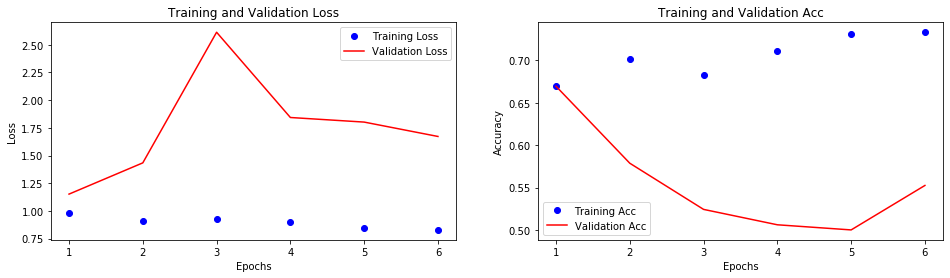

In [23]:
draw_training_validation_graph(points_histories[(512,512)][3])

In [24]:
"""
3. Keras Feedfoward neural network with regularization
"""
regularized_points_histories = {}
for hidden_layer in [(128,128,128,128),(256,256,256), (256,256,256,256), (512,512), (512,512,512),(1024,),(1024,1024), (2048,)]:
    model = create_regularized_ff_model((156,), hidden_layer, l2= 0.001, optimizer='adam')
    hist, acc = k_fold_feedforward_points(model,X_points, y)
    regularized_points_histories[hidden_layer] = hist
    print(f"Average accuracy of the NeuralNetwork Model with hidden units {hidden_layer}: ", acc)

Average accuracy of the NeuralNetwork Model with hidden units (128, 128, 128, 128):  0.4855153143405914
Average accuracy of the NeuralNetwork Model with hidden units (256, 256, 256):  0.5239941358566285
Average accuracy of the NeuralNetwork Model with hidden units (256, 256, 256, 256):  0.49194015860557555
Average accuracy of the NeuralNetwork Model with hidden units (512, 512):  0.5290333449840545
Average accuracy of the NeuralNetwork Model with hidden units (512, 512, 512):  0.5159281313419342
Average accuracy of the NeuralNetwork Model with hidden units (1024,):  0.4863728702068329
Average accuracy of the NeuralNetwork Model with hidden units (1024, 1024):  0.5357576787471772
Average accuracy of the NeuralNetwork Model with hidden units (2048,):  0.48773908615112305


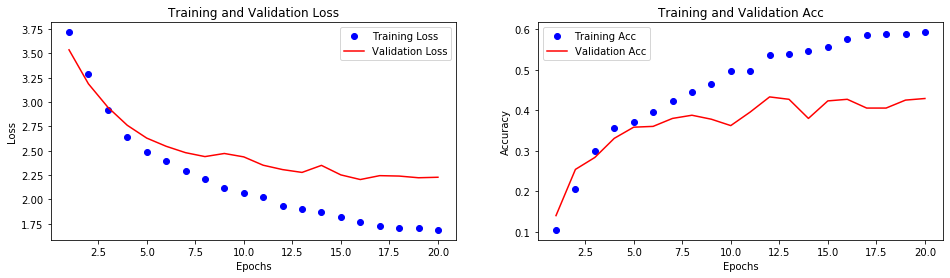

In [25]:
draw_training_validation_graph(regularized_points_histories[(512,512)][0])

## Feedforward Neural Network Using Images

In [26]:
"""
Flatten the image to feed feedforward neural network
"""
X_flat_images = images.reshape((-1, height * width))
X_flat_images.shape

(2500, 40000)

In [34]:
images_histories = {}
# underfitting (64,64),
# overfitting? (64,64,48),(128,128), (256,256), (512,512)
# (64,64,48),(128,128),(256,256),

for hidden_layer in [(512,512),(512,512,512),(1024,1024),(1024,1024,1024)]:
    model = create_regularized_ff_model((height*width,), hidden_layer, optimizer = 'rmsprop', l2= 0.001)
    hist, acc = k_fold_feedforward_points(model, X_flat_images, y)
    images_histories[hidden_layer] = hist
    print("feedforward neural network with hidden layer :", hidden_layer , acc)

feedforward neural network with hidden layer : (512, 512) 0.3752795934677124
feedforward neural network with hidden layer : (512, 512, 512) 0.355800473690033
feedforward neural network with hidden layer : (1024, 1024) 0.33820762038230895
feedforward neural network with hidden layer : (1024, 1024, 1024) 0.2510475665330887


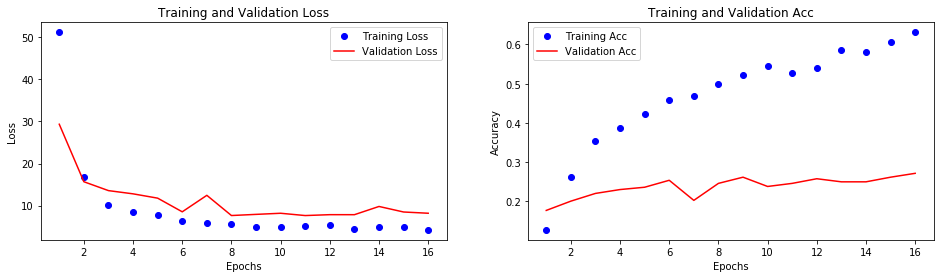

In [35]:
draw_training_validation_graph(images_histories[(512,512)][0])

## Convolutional Neural Network

In [36]:
def create_CNN_model(height = 300, width = 400, dim = 1, convolution_layers = (), dense_layers = (), outputs = 22):
    """
    
    """
    model = models.Sequential()
    if len(convolution_layers) < 1:
        raise Exception("Wrong layers parameters")
        
    # input 
    model.add(layers.Conv2D(convolution_layers[0], (3,3), activation = 'relu', input_shape = (height, width, dim)))
    model.add(layers.MaxPool2D(2,2))
    
    # hidden
    for depth in range(1, len(convolution_layers)):
        model.add(layers.Conv2D(depth,(3,3), activation = 'relu'))
        model.add(layers.MaxPool2D(2,2))
        
    # output
    model.add(layers.Flatten())
    for layer in dense_layers:
        model.add(layers.Dense(layer, activation = 'relu'))
    
    model.add(layers.Dense(outputs, activation = 'softmax'))
    
    model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [37]:
"""
K-fold validation using data augmentation
"""
def k_fold_convolutional_model(model, X, y, fold = 5, random_state = 13):
    
    kfold = StratifiedKFold(n_splits=fold, shuffle=True, random_state=random_state)

    train_datagen = ImageDataGenerator(rescale=1/255,
                                      rotation_range= 40,
                                       width_shift_range=0.2, 
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                      zoom_range=0.2,
                                       horizontal_flip= True)

    test_datagen = ImageDataGenerator(rescale=1/255)
    
    avg_accuracy = 0
    for train_index, val_index in kfold.split(X, y):
        # split traning set and validation set
        X_train = X[train_index]
        y_train = y[train_index]

        X_test = X[val_index]
        y_test = y[val_index]
        
        y_train = to_categorical(y_train)
        y_test = to_categorical(y_test)

        
        # create data generator
        train_generator = train_datagen.flow(X_train, 
                                             y_train, 
                                             batch_size = 50, 
                                             shuffle = True, 
                                             seed = random_state)
        test_generator = test_datagen.flow(X_test, y_test,
                                                       batch_size = 20, 
                                                       seed = random_state)
        
        callbacks = [
          EarlyStopping(
            monitor='val_loss', patience=5, verbose=0)
          ]
        
        history = model.fit_generator(train_generator, 
                                      epochs = 20, 
                                      steps_per_epoch = 50, 
                                      validation_data = test_generator, 
                                      validation_steps = 25,
                                      workers = 6,
                                      shuffle = True,
                                      callbacks = callbacks
                                         )
        print(model.predict(X_test))
        histories.append(history)
        avg_accuracy += model.evaluate(X_test, y_test, verbose = False)[1]
        
    return histories, avg_accuracy / fold


In [38]:
conv_histories = {}

for conv_layer in [[64,128], [128,128],[64,128,128,256],[64,64,128,128],[64,64,128,128,256,512],[64,128,256,512]]:
    model  = create_CNN_model(height, width, 1,[64,128], [512])
    hist, acc = k_fold_convolutional_model(model, images, y)
    conv_histories[conv_layer] = hist
    print(f"Accuracy of convolutional neural network with hidden layer {conv_layer}:", acc)

Epoch 1/20
50/50 [==============================] - 51s 1s/step - loss: 3.0926 - accuracy: 0.0365 - val_loss: 3.0944 - val_accuracy: 0.0540
Epoch 2/20
50/50 [==============================] - 50s 1s/step - loss: 3.0906 - accuracy: 0.0526 - val_loss: 3.0974 - val_accuracy: 0.0553
Epoch 3/20
50/50 [==============================] - 50s 1s/step - loss: 3.0906 - accuracy: 0.0527 - val_loss: 3.0923 - val_accuracy: 0.0492
Epoch 4/20
50/50 [==============================] - 50s 1s/step - loss: 3.0899 - accuracy: 0.0534 - val_loss: 3.0885 - val_accuracy: 0.0512
Epoch 5/20
50/50 [==============================] - 50s 1s/step - loss: 3.0895 - accuracy: 0.0534 - val_loss: 3.1032 - val_accuracy: 0.0615
Epoch 6/20
50/50 [==============================] - 50s 1s/step - loss: 3.0894 - accuracy: 0.0531 - val_loss: 3.0814 - val_accuracy: 0.0492
Epoch 7/20
50/50 [==============================] - 50s 1s/step - loss: 3.0894 - accuracy: 0.0566 - val_loss: 3.0903 - val_accuracy: 0.0512
Epoch 8/20
50/50 [==

NameError: name 'histories' is not defined